In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=1):
    channel_size = 32
    
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=channel_size, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D (kernel_size=3, filters=channel_size, strides=1, padding='same')) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=channel_size*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv1D (kernel_size=3, filters=channel_size*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=2, strides=2))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 14):
    model = build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 32)         128       
_________________________________________________________________
activation (Activation)      (None, 16000, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 32)         128       
_________________________________________________________________
activation_1 (Activat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_20 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_21 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 32)         3104      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_42 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_43 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16000, 32)         3104      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_72 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_72 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 32)         3104      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_90 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_91 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_91 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 16000, 32)         3104      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_110 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_110 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_110 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_111 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_111 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_112 (Conv1D)          (None, 16000, 32)         3104      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_132 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_132 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_132 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_133 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_133 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_134 (Conv1D)          (None, 16000, 32)         3104      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_156 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_156 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_156 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_157 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_157 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_157 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_158 (Conv1D)          (None, 16000, 32)         3104      
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4862 - acc: 0.3072
Epoch 00001: val_loss improved from inf to 2.04571, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_3_conv_checkpoint/001-2.0457.hdf5
36805/36805 [==============================] - 92s 3ms/sample - loss: 2.4863 - acc: 0.3072 - val_loss: 2.0457 - val_acc: 0.3538
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6876 - acc: 0.4980
Epoch 00002: val_loss improved from 2.04571 to 1.69938, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_3_conv_checkpoint/002-1.6994.hdf5
36805/36805 [==============================] - 83s 2ms/sample - loss: 1.6877 - acc: 0.4980 - val_loss: 1.6994 - val_acc: 0.5108
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3139 - acc: 0.6055
Epoch 00003: val_loss did not

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1012 - acc: 0.9702
Epoch 00029: val_loss did not improve from 1.69938
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.1012 - acc: 0.9701 - val_loss: 3.0232 - val_acc: 0.5181
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0873 - acc: 0.9746
Epoch 00030: val_loss did not improve from 1.69938
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0873 - acc: 0.9746 - val_loss: 2.5253 - val_acc: 0.5649
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0957 - acc: 0.9713
Epoch 00031: val_loss did not improve from 1.69938
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0958 - acc: 0.9713 - val_loss: 2.7900 - val_acc: 0.5320
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0948 - acc: 0.9724
Epoch 00032: val_loss did not improve from 1.69938
36805/36805 [===========

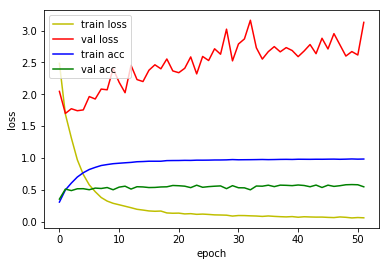

4815/4815 [==============================] - 4s 921us/sample - loss: 1.7901 - acc: 0.4741
Loss: 1.7900645954710424 Accuracy: 0.4741433

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4832 - acc: 0.3126
Epoch 00001: val_loss improved from inf to 1.76034, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_4_conv_checkpoint/001-1.7603.hdf5
36805/36805 [==============================] - 105s 3ms/sample - loss: 2.4831 - acc: 0.3127 - val_loss: 1.7603 - val_acc: 0.4547
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6443 - acc: 0.5017
Epoch 00002: val_loss improved from 1.76034 to 1.51407, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_4_conv_checkpoint/002-1.5141.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.6441 - acc: 0.5017 - val_loss: 1.5141 - val_acc: 0.5332
Epoch 3/500
36800/36805 [===========

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1436 - acc: 0.9558
Epoch 00028: val_loss did not improve from 1.23576
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1436 - acc: 0.9558 - val_loss: 2.0255 - val_acc: 0.6201
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1430 - acc: 0.9545
Epoch 00029: val_loss did not improve from 1.23576
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1430 - acc: 0.9545 - val_loss: 1.6299 - val_acc: 0.6636
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1303 - acc: 0.9593
Epoch 00030: val_loss did not improve from 1.23576
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1303 - acc: 0.9594 - val_loss: 1.6175 - val_acc: 0.6639
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1248 - acc: 0.9615
Epoch 00031: val_loss did not improve from 1.23576
36805/36805 [===========

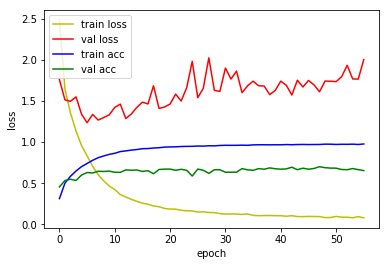

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.3347 - acc: 0.5981
Loss: 1.3346540165096057 Accuracy: 0.5981308

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3475 - acc: 0.3321
Epoch 00001: val_loss improved from inf to 2.00329, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_5_conv_checkpoint/001-2.0033.hdf5
36805/36805 [==============================] - 119s 3ms/sample - loss: 2.3476 - acc: 0.3321 - val_loss: 2.0033 - val_acc: 0.3811
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5479 - acc: 0.5287
Epoch 00002: val_loss improved from 2.00329 to 1.33594, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_5_conv_checkpoint/002-1.3359.hdf5
36805/36805 [==============================] - 100s 3ms/sample - loss: 1.5479 - acc: 0.5287 - val_loss: 1.3359 - val_acc: 0.6059
Epoch 3/500
36800/36805 [============

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1291 - acc: 0.9598
Epoch 00028: val_loss did not improve from 1.13811
36805/36805 [==============================] - 100s 3ms/sample - loss: 0.1291 - acc: 0.9598 - val_loss: 1.3824 - val_acc: 0.7130
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1251 - acc: 0.9609
Epoch 00029: val_loss did not improve from 1.13811
36805/36805 [==============================] - 100s 3ms/sample - loss: 0.1251 - acc: 0.9609 - val_loss: 1.5275 - val_acc: 0.7081
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1145 - acc: 0.9640
Epoch 00030: val_loss did not improve from 1.13811
36805/36805 [==============================] - 100s 3ms/sample - loss: 0.1146 - acc: 0.9639 - val_loss: 1.4412 - val_acc: 0.7186
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1085 - acc: 0.9672
Epoch 00031: val_loss did not improve from 1.13811
36805/36805 [========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0740 - acc: 0.9780
Epoch 00058: val_loss did not improve from 1.13811
36805/36805 [==============================] - 100s 3ms/sample - loss: 0.0740 - acc: 0.9780 - val_loss: 1.4291 - val_acc: 0.7447
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0708 - acc: 0.9792
Epoch 00059: val_loss did not improve from 1.13811
36805/36805 [==============================] - 100s 3ms/sample - loss: 0.0708 - acc: 0.9792 - val_loss: 1.5077 - val_acc: 0.7386
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0690 - acc: 0.9793
Epoch 00060: val_loss did not improve from 1.13811
36805/36805 [==============================] - 100s 3ms/sample - loss: 0.0692 - acc: 0.9793 - val_loss: 1.5901 - val_acc: 0.7167
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0770 - acc: 0.9775
Epoch 00061: val_loss did not improve from 1.13811
36805/36805 [========

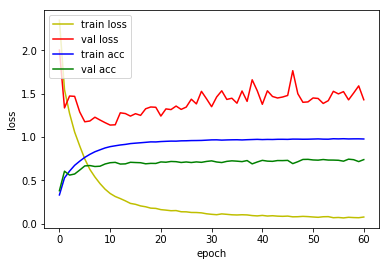

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.2683 - acc: 0.6567
Loss: 1.2683235645541768 Accuracy: 0.6566978

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2820 - acc: 0.3200
Epoch 00001: val_loss improved from inf to 1.70820, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_6_conv_checkpoint/001-1.7082.hdf5
36805/36805 [==============================] - 135s 4ms/sample - loss: 2.2819 - acc: 0.3200 - val_loss: 1.7082 - val_acc: 0.4608
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5300 - acc: 0.5208
Epoch 00002: val_loss improved from 1.70820 to 1.22487, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_6_conv_checkpoint/002-1.2249.hdf5
36805/36805 [==============================] - 104s 3ms/sample - loss: 1.5303 - acc: 0.5208 - val_loss: 1.2249 - val_acc: 0.6143
Epoch 3/500
36800/36805 [============

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2031 - acc: 0.9350
Epoch 00026: val_loss did not improve from 0.76965
36805/36805 [==============================] - 104s 3ms/sample - loss: 0.2030 - acc: 0.9350 - val_loss: 0.8620 - val_acc: 0.7883
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1863 - acc: 0.9402
Epoch 00027: val_loss did not improve from 0.76965
36805/36805 [==============================] - 104s 3ms/sample - loss: 0.1865 - acc: 0.9402 - val_loss: 0.8819 - val_acc: 0.7906
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1790 - acc: 0.9422
Epoch 00028: val_loss did not improve from 0.76965
36805/36805 [==============================] - 104s 3ms/sample - loss: 0.1793 - acc: 0.9422 - val_loss: 0.8517 - val_acc: 0.8083
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1767 - acc: 0.9430
Epoch 00029: val_loss did not improve from 0.76965
36805/36805 [========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0993 - acc: 0.9694
Epoch 00056: val_loss did not improve from 0.76965
36805/36805 [==============================] - 104s 3ms/sample - loss: 0.0995 - acc: 0.9694 - val_loss: 1.0005 - val_acc: 0.7997
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0960 - acc: 0.9707
Epoch 00057: val_loss did not improve from 0.76965
36805/36805 [==============================] - 104s 3ms/sample - loss: 0.0960 - acc: 0.9707 - val_loss: 1.0396 - val_acc: 0.7843
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0925 - acc: 0.9719
Epoch 00058: val_loss did not improve from 0.76965
36805/36805 [==============================] - 104s 3ms/sample - loss: 0.0925 - acc: 0.9719 - val_loss: 1.0704 - val_acc: 0.7983
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0938 - acc: 0.9696
Epoch 00059: val_loss did not improve from 0.76965
36805/36805 [========

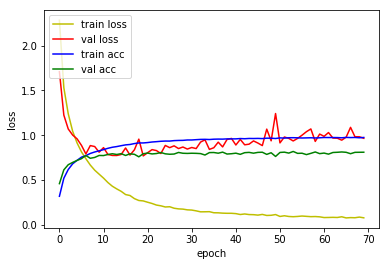

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.8936 - acc: 0.7570
Loss: 0.8935574294374492 Accuracy: 0.7570093

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5153 - acc: 0.2480
Epoch 00001: val_loss improved from inf to 2.04073, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_7_conv_checkpoint/001-2.0407.hdf5
36805/36805 [==============================] - 148s 4ms/sample - loss: 2.5153 - acc: 0.2480 - val_loss: 2.0407 - val_acc: 0.3543
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6430 - acc: 0.4767
Epoch 00002: val_loss improved from 2.04073 to 1.27347, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_7_conv_checkpoint/002-1.2735.hdf5
36805/36805 [==============================] - 108s 3ms/sample - loss: 1.6430 - acc: 0.4768 - val_loss: 1.2735 - val_acc: 0.6007
Epoch 3/500
36800/36805 [============

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3020 - acc: 0.9067
Epoch 00025: val_loss did not improve from 0.58737
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.3020 - acc: 0.9066 - val_loss: 0.6448 - val_acc: 0.8258
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2957 - acc: 0.9083
Epoch 00026: val_loss did not improve from 0.58737
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.2957 - acc: 0.9083 - val_loss: 0.6334 - val_acc: 0.8300
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2715 - acc: 0.9152
Epoch 00027: val_loss did not improve from 0.58737
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.2715 - acc: 0.9152 - val_loss: 0.5895 - val_acc: 0.8442
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2638 - acc: 0.9171
Epoch 00028: val_loss did not improve from 0.58737
36805/36805 [========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1299 - acc: 0.9595
Epoch 00055: val_loss did not improve from 0.58737
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.1299 - acc: 0.9595 - val_loss: 0.6652 - val_acc: 0.8507
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1273 - acc: 0.9609
Epoch 00056: val_loss did not improve from 0.58737
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.1274 - acc: 0.9608 - val_loss: 0.7181 - val_acc: 0.8470
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1314 - acc: 0.9589
Epoch 00057: val_loss did not improve from 0.58737
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.1314 - acc: 0.9589 - val_loss: 0.7146 - val_acc: 0.8477
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1179 - acc: 0.9627
Epoch 00058: val_loss did not improve from 0.58737
36805/36805 [========

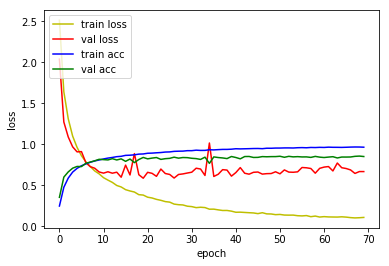

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.6763 - acc: 0.8073
Loss: 0.6762765360398456 Accuracy: 0.807269

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5579 - acc: 0.2335
Epoch 00001: val_loss improved from inf to 2.20675, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_8_conv_checkpoint/001-2.2068.hdf5
36805/36805 [==============================] - 158s 4ms/sample - loss: 2.5578 - acc: 0.2335 - val_loss: 2.2068 - val_acc: 0.2970
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6794 - acc: 0.4641
Epoch 00002: val_loss improved from 2.20675 to 1.25153, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_8_conv_checkpoint/002-1.2515.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 1.6795 - acc: 0.4641 - val_loss: 1.2515 - val_acc: 0.6150
Epoch 3/500
36800/36805 [=============

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2534 - acc: 0.9226
Epoch 00026: val_loss did not improve from 0.46650
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.2535 - acc: 0.9225 - val_loss: 0.4755 - val_acc: 0.8779
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2566 - acc: 0.9210
Epoch 00027: val_loss did not improve from 0.46650
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.2569 - acc: 0.9210 - val_loss: 0.5631 - val_acc: 0.8556
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2452 - acc: 0.9229
Epoch 00028: val_loss did not improve from 0.46650
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.2455 - acc: 0.9228 - val_loss: 0.5284 - val_acc: 0.8682
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2340 - acc: 0.9272
Epoch 00029: val_loss improved from 0.46650 to 0.46284, saving model to 

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1094 - acc: 0.9654
Epoch 00054: val_loss did not improve from 0.41647
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.1094 - acc: 0.9654 - val_loss: 0.4814 - val_acc: 0.8924
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1112 - acc: 0.9635
Epoch 00055: val_loss did not improve from 0.41647
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.1112 - acc: 0.9635 - val_loss: 0.4703 - val_acc: 0.8915
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1070 - acc: 0.9655
Epoch 00056: val_loss did not improve from 0.41647
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.1070 - acc: 0.9655 - val_loss: 0.5224 - val_acc: 0.8884
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1066 - acc: 0.9649
Epoch 00057: val_loss did not improve from 0.41647
36805/36805 [========

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0788 - acc: 0.9751
Epoch 00084: val_loss did not improve from 0.41647
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0788 - acc: 0.9751 - val_loss: 0.4591 - val_acc: 0.9036
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0619 - acc: 0.9813
Epoch 00085: val_loss did not improve from 0.41647
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0619 - acc: 0.9813 - val_loss: 0.5263 - val_acc: 0.8973
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0742 - acc: 0.9763
Epoch 00086: val_loss did not improve from 0.41647
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0742 - acc: 0.9763 - val_loss: 0.5098 - val_acc: 0.8938

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_8_conv Model


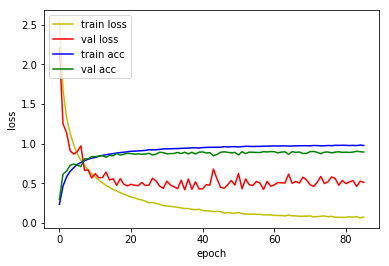

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.5044 - acc: 0.8658
Loss: 0.5043950633715494 Accuracy: 0.8658359

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6045 - acc: 0.2252
Epoch 00001: val_loss improved from inf to 2.15517, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_9_conv_checkpoint/001-2.1552.hdf5
36805/36805 [==============================] - 172s 5ms/sample - loss: 2.6044 - acc: 0.2253 - val_loss: 2.1552 - val_acc: 0.2842
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6273 - acc: 0.4785
Epoch 00002: val_loss improved from 2.15517 to 1.30786, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_9_conv_checkpoint/002-1.3079.hdf5
36805/36805 [==============================] - 108s 3ms/sample - loss: 1.6272 - acc: 0.4785 - val_loss: 1.3079 - val_acc: 0.5989
Epoch 3/500
36800/36805 [============

36800/36805 [============================>.] - ETA: 0s - loss: 0.1792 - acc: 0.9442
Epoch 00024: val_loss improved from 0.30538 to 0.30137, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_9_conv_checkpoint/024-0.3014.hdf5
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.1793 - acc: 0.9441 - val_loss: 0.3014 - val_acc: 0.9147
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1714 - acc: 0.9443
Epoch 00025: val_loss did not improve from 0.30137
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.1715 - acc: 0.9442 - val_loss: 0.3524 - val_acc: 0.9085
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1633 - acc: 0.9491
Epoch 00026: val_loss did not improve from 0.30137
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.1634 - acc: 0.9491 - val_loss: 0.3443 - val_acc: 0.9092
Epoch 27/500
36800/36805 [============================>.] - ETA: 0

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0769 - acc: 0.9754
Epoch 00053: val_loss did not improve from 0.28978
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.0769 - acc: 0.9754 - val_loss: 0.3434 - val_acc: 0.9189
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0568 - acc: 0.9820
Epoch 00054: val_loss improved from 0.28978 to 0.28776, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_9_conv_checkpoint/054-0.2878.hdf5
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0571 - acc: 0.9820 - val_loss: 0.2878 - val_acc: 0.9299
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0686 - acc: 0.9777
Epoch 00055: val_loss did not improve from 0.28776
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.0687 - acc: 0.9776 - val_loss: 0.3318 - val_acc: 0.9259
Epoch 56/500
36800/36805 [===========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0400 - acc: 0.9873
Epoch 00082: val_loss did not improve from 0.28776
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.0400 - acc: 0.9873 - val_loss: 0.3492 - val_acc: 0.9292
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0410 - acc: 0.9869
Epoch 00083: val_loss did not improve from 0.28776
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.0412 - acc: 0.9868 - val_loss: 0.3573 - val_acc: 0.9292
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0459 - acc: 0.9849
Epoch 00084: val_loss did not improve from 0.28776
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.0459 - acc: 0.9849 - val_loss: 0.3643 - val_acc: 0.9255
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0374 - acc: 0.9886
Epoch 00085: val_loss did not improve from 0.28776
36805/36805 [=====================

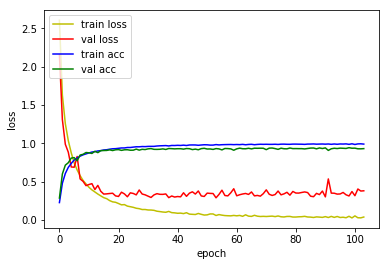

4815/4815 [==============================] - 7s 2ms/sample - loss: 0.3428 - acc: 0.9111
Loss: 0.34281196426039295 Accuracy: 0.9111111

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.8133 - acc: 0.1626
Epoch 00001: val_loss improved from inf to 2.29843, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_10_conv_checkpoint/001-2.2984.hdf5
36805/36805 [==============================] - 198s 5ms/sample - loss: 2.8132 - acc: 0.1626 - val_loss: 2.2984 - val_acc: 0.2211
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0138 - acc: 0.3630
Epoch 00002: val_loss improved from 2.29843 to 1.50403, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_10_conv_checkpoint/002-1.5040.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 2.0140 - acc: 0.3630 - val_loss: 1.5040 - val_acc: 0.5451
Epoch 3/500
36800/36805 [=========

36800/36805 [============================>.] - ETA: 0s - loss: 0.1346 - acc: 0.9557
Epoch 00024: val_loss did not improve from 0.20813
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.1345 - acc: 0.9557 - val_loss: 0.3236 - val_acc: 0.9080
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1281 - acc: 0.9585
Epoch 00025: val_loss did not improve from 0.20813
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.1281 - acc: 0.9584 - val_loss: 0.2713 - val_acc: 0.9250
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1276 - acc: 0.9580
Epoch 00026: val_loss did not improve from 0.20813
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.1276 - acc: 0.9579 - val_loss: 0.7711 - val_acc: 0.8139
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1160 - acc: 0.9613
Epoch 00027: val_loss did not improve from 0.20813
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0536 - acc: 0.9826
Epoch 00053: val_loss did not improve from 0.18733
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.0536 - acc: 0.9825 - val_loss: 0.2555 - val_acc: 0.9364
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0488 - acc: 0.9838
Epoch 00054: val_loss did not improve from 0.18733
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.0488 - acc: 0.9838 - val_loss: 0.1912 - val_acc: 0.9534
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0371 - acc: 0.9880
Epoch 00055: val_loss did not improve from 0.18733
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.0371 - acc: 0.9880 - val_loss: 0.2586 - val_acc: 0.9394
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0382 - acc: 0.9878
Epoch 00056: val_loss did not improve from 0.18733
36805/36805 [=====================

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0202 - acc: 0.9942
Epoch 00083: val_loss did not improve from 0.18733
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0205 - acc: 0.9942 - val_loss: 0.2686 - val_acc: 0.9476
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0329 - acc: 0.9895
Epoch 00084: val_loss did not improve from 0.18733
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0329 - acc: 0.9895 - val_loss: 0.2366 - val_acc: 0.9525

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_10_conv Model


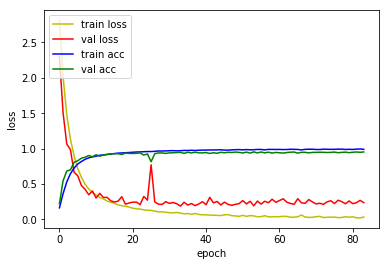

4815/4815 [==============================] - 7s 2ms/sample - loss: 0.2554 - acc: 0.9288
Loss: 0.2554334831262551 Accuracy: 0.9287643

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7973 - acc: 0.1733
Epoch 00001: val_loss improved from inf to 2.20146, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_11_conv_checkpoint/001-2.2015.hdf5
36805/36805 [==============================] - 220s 6ms/sample - loss: 2.7972 - acc: 0.1733 - val_loss: 2.2015 - val_acc: 0.2905
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9529 - acc: 0.3781
Epoch 00002: val_loss improved from 2.20146 to 1.34449, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_11_conv_checkpoint/002-1.3445.hdf5
36805/36805 [==============================] - 111s 3ms/sample - loss: 1.9529 - acc: 0.3782 - val_loss: 1.3445 - val_acc: 0.5786
Epoch 3/500
36800/36805 [==========

36800/36805 [============================>.] - ETA: 0s - loss: 0.1039 - acc: 0.9663
Epoch 00024: val_loss improved from 0.18472 to 0.17705, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_11_conv_checkpoint/024-0.1771.hdf5
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.1039 - acc: 0.9663 - val_loss: 0.1771 - val_acc: 0.9527
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0973 - acc: 0.9684
Epoch 00025: val_loss did not improve from 0.17705
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0975 - acc: 0.9684 - val_loss: 0.1838 - val_acc: 0.9532
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1019 - acc: 0.9669
Epoch 00026: val_loss improved from 0.17705 to 0.16812, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_11_conv_checkpoint/026-0.1681.hdf5
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.1019

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0366 - acc: 0.9882
Epoch 00052: val_loss did not improve from 0.15643
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0366 - acc: 0.9882 - val_loss: 0.2142 - val_acc: 0.9513
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0342 - acc: 0.9892
Epoch 00053: val_loss did not improve from 0.15643
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0342 - acc: 0.9892 - val_loss: 0.2998 - val_acc: 0.9392
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0366 - acc: 0.9880
Epoch 00054: val_loss did not improve from 0.15643
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0366 - acc: 0.9880 - val_loss: 0.1856 - val_acc: 0.9541
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0311 - acc: 0.9903
Epoch 00055: val_loss did not improve from 0.15643
36805/36805 [========

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0300 - acc: 0.9901
Epoch 00082: val_loss did not improve from 0.15643
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0300 - acc: 0.9901 - val_loss: 0.2567 - val_acc: 0.9495
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0173 - acc: 0.9945
Epoch 00083: val_loss did not improve from 0.15643
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0173 - acc: 0.9945 - val_loss: 0.1802 - val_acc: 0.9620
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0154 - acc: 0.9956
Epoch 00084: val_loss did not improve from 0.15643
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0156 - acc: 0.9956 - val_loss: 0.2158 - val_acc: 0.9499
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0306 - acc: 0.9899
Epoch 00085: val_loss did not improve from 0.15643
36805/36805 [========

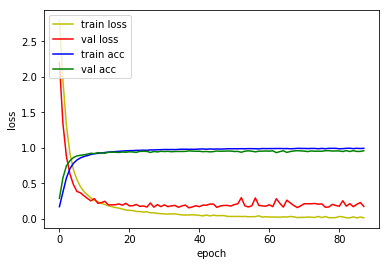

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.1748 - acc: 0.9497
Loss: 0.17475470805295035 Accuracy: 0.9497404

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.8864 - acc: 0.1546
Epoch 00001: val_loss improved from inf to 2.22280, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_12_conv_checkpoint/001-2.2228.hdf5
36805/36805 [==============================] - 250s 7ms/sample - loss: 2.8864 - acc: 0.1546 - val_loss: 2.2228 - val_acc: 0.2844
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8706 - acc: 0.4039
Epoch 00002: val_loss improved from 2.22280 to 1.28113, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_12_conv_checkpoint/002-1.2811.hdf5
36805/36805 [==============================] - 115s 3ms/sample - loss: 1.8709 - acc: 0.4039 - val_loss: 1.2811 - val_acc: 0.5975
Epoch 3/500
36800/36805 [=========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0967 - acc: 0.9690
Epoch 00024: val_loss did not improve from 0.14998
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.0967 - acc: 0.9690 - val_loss: 0.1592 - val_acc: 0.9511
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0896 - acc: 0.9712
Epoch 00025: val_loss did not improve from 0.14998
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.0896 - acc: 0.9712 - val_loss: 0.1626 - val_acc: 0.9515
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0882 - acc: 0.9715
Epoch 00026: val_loss did not improve from 0.14998
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.0884 - acc: 0.9715 - val_loss: 0.1664 - val_acc: 0.9502
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0898 - acc: 0.9716
Epoch 00027: val_loss did not improve from 0.14998
36805/36805 [=====================

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0342 - acc: 0.9893
Epoch 00053: val_loss did not improve from 0.13133
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.0343 - acc: 0.9893 - val_loss: 0.1993 - val_acc: 0.9497
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0437 - acc: 0.9860
Epoch 00054: val_loss did not improve from 0.13133
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.0437 - acc: 0.9860 - val_loss: 0.1455 - val_acc: 0.9641
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0337 - acc: 0.9894
Epoch 00055: val_loss did not improve from 0.13133
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.0337 - acc: 0.9894 - val_loss: 0.1868 - val_acc: 0.9515
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0335 - acc: 0.9892
Epoch 00056: val_loss did not improve from 0.13133
36805/36805 [========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0191 - acc: 0.9937
Epoch 00083: val_loss did not improve from 0.13133
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.0191 - acc: 0.9937 - val_loss: 0.1841 - val_acc: 0.9576
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0179 - acc: 0.9942
Epoch 00084: val_loss did not improve from 0.13133
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.0179 - acc: 0.9942 - val_loss: 0.1867 - val_acc: 0.9555
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0217 - acc: 0.9930
Epoch 00085: val_loss did not improve from 0.13133
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.0217 - acc: 0.9929 - val_loss: 0.1717 - val_acc: 0.9632
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0234 - acc: 0.9927
Epoch 00086: val_loss did not improve from 0.13133
36805/36805 [========

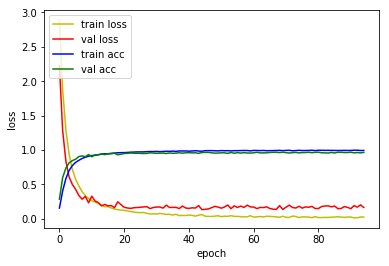

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.1884 - acc: 0.9514
Loss: 0.1884096939607039 Accuracy: 0.9514019

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6858 - acc: 0.2153
Epoch 00001: val_loss improved from inf to 1.94813, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_13_conv_checkpoint/001-1.9481.hdf5
36805/36805 [==============================] - 288s 8ms/sample - loss: 2.6858 - acc: 0.2152 - val_loss: 1.9481 - val_acc: 0.3613
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5621 - acc: 0.5067
Epoch 00002: val_loss improved from 1.94813 to 1.02734, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_13_conv_checkpoint/002-1.0273.hdf5
36805/36805 [==============================] - 117s 3ms/sample - loss: 1.5621 - acc: 0.5067 - val_loss: 1.0273 - val_acc: 0.6725
Epoch 3/500
36800/36805 [==========

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0854 - acc: 0.9720
Epoch 00025: val_loss did not improve from 0.17643
36805/36805 [==============================] - 117s 3ms/sample - loss: 0.0855 - acc: 0.9720 - val_loss: 0.1868 - val_acc: 0.9453
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0801 - acc: 0.9743
Epoch 00026: val_loss did not improve from 0.17643
36805/36805 [==============================] - 117s 3ms/sample - loss: 0.0801 - acc: 0.9744 - val_loss: 0.2360 - val_acc: 0.9350
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0658 - acc: 0.9789
Epoch 00027: val_loss improved from 0.17643 to 0.17278, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_13_conv_checkpoint/027-0.1728.hdf5
36805/36805 [==============================] - 117s 3ms/sample - loss: 0.0659 - acc: 0.9788 - val_loss: 0.1728 - val_acc: 0.9502
Epoch 28/500
36800/36805 [==========================

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0258 - acc: 0.9915
Epoch 00054: val_loss did not improve from 0.15312
36805/36805 [==============================] - 117s 3ms/sample - loss: 0.0258 - acc: 0.9915 - val_loss: 0.2186 - val_acc: 0.9504
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0231 - acc: 0.9922
Epoch 00055: val_loss did not improve from 0.15312
36805/36805 [==============================] - 117s 3ms/sample - loss: 0.0236 - acc: 0.9921 - val_loss: 0.2055 - val_acc: 0.9557
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0444 - acc: 0.9861
Epoch 00056: val_loss did not improve from 0.15312
36805/36805 [==============================] - 117s 3ms/sample - loss: 0.0447 - acc: 0.9861 - val_loss: 0.1776 - val_acc: 0.9590
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0350 - acc: 0.9891
Epoch 00057: val_loss did not improve from 0.15312
36805/36805 [========

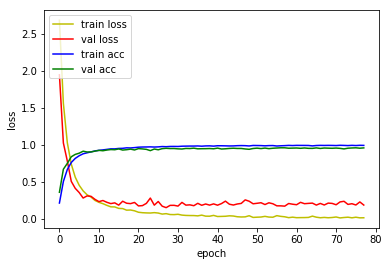

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2178 - acc: 0.9377
Loss: 0.2177782718862019 Accuracy: 0.9376947



In [10]:
base = '1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN'

for i in range(3, 14):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 14):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_182 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_182 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_182 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_183 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_183 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_183 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_184 (Conv1D

4815/4815 [==============================] - 10s 2ms/sample - loss: 1.2683 - acc: 0.6567
Loss: 1.2683235645541768 Accuracy: 0.6566978

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_206 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_206 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_206 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_207 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_207 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_207 (

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.6763 - acc: 0.8073
Loss: 0.6762765360398456 Accuracy: 0.807269

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_232 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_232 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_232 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_233 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_233 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_233 (A

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.5044 - acc: 0.8658
Loss: 0.5043950633715494 Accuracy: 0.8658359

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_248 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_248 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_248 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_249 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_249 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_249 (

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.3428 - acc: 0.9111
Loss: 0.34281196426039295 Accuracy: 0.9111111

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_10_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_266 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_266 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_266 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_267 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_267 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_267

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.2554 - acc: 0.9288
Loss: 0.2554334831262551 Accuracy: 0.9287643

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_11_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_286 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_286 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_286 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_287 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_287 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_287 

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.1748 - acc: 0.9497
Loss: 0.17475470805295035 Accuracy: 0.9497404

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_12_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_308 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_308 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_308 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_309 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_309 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_309

4815/4815 [==============================] - 12s 2ms/sample - loss: 0.1884 - acc: 0.9514
Loss: 0.1884096939607039 Accuracy: 0.9514019

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_13_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_332 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_332 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_332 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_333 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_333 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_333 

4815/4815 [==============================] - 12s 3ms/sample - loss: 0.2178 - acc: 0.9377
Loss: 0.2177782718862019 Accuracy: 0.9376947


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 14):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_182 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_182 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_182 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_183 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_183 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_183 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_184 (Conv1D

4815/4815 [==============================] - 12s 2ms/sample - loss: 1.6982 - acc: 0.6926
Loss: 1.6982337263885687 Accuracy: 0.6926272

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_206 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_206 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_206 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_207 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_207 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_207 (

4815/4815 [==============================] - 12s 2ms/sample - loss: 0.7765 - acc: 0.8249
Loss: 0.7764819572152626 Accuracy: 0.82492214

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_232 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_232 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_232 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_233 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_233 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_233 

4815/4815 [==============================] - 12s 2ms/sample - loss: 0.5453 - acc: 0.8798
Loss: 0.5453438074294157 Accuracy: 0.8797508

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_248 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_248 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_248 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_249 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_249 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_249 (

4815/4815 [==============================] - 12s 3ms/sample - loss: 0.4851 - acc: 0.9076
Loss: 0.48512392078012784 Accuracy: 0.9075805

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_10_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_266 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_266 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_266 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_267 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_267 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_267

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.2750 - acc: 0.9358
Loss: 0.2749593847362578 Accuracy: 0.9358255

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_11_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_286 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_286 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_286 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_287 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_287 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_287 

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.1909 - acc: 0.9526
Loss: 0.19093569252214 Accuracy: 0.952648

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_12_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_308 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_308 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_308 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_309 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_309 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_309 (Ac

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.1998 - acc: 0.9572
Loss: 0.19977801913764656 Accuracy: 0.95721704

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_DO_BN_13_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_332 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_332 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_332 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_333 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_333 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_33

4815/4815 [==============================] - 14s 3ms/sample - loss: 0.2355 - acc: 0.9493
Loss: 0.23551768435456386 Accuracy: 0.949325
